

# Project: Investigate TMDb movie data set

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

### Question(s) for Analysis
 

In [1]:
# Using this cell to set up import statements for all of the packages that are considered to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

"""Changing scientific numbers to numeric numbers"""
#https://stackoverflow.com/questions/38689125/how-to-get-rid-of-pandas-converting-large-numbers-in-excel-sheet-to-exponential
pd.options.display.float_format = '{:.2f}'.format


<a id='wrangling'></a>
## Data Wrangling
### General Properties


In [2]:
# Loading the data and having a look at the first few lines
df = pd.read_csv('tmdb-movies.csv')
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.99,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.50,2015,137999939.28,1392445892.52
1,76341,tt1392190,28.42,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.10,2015,137999939.28,348161292.49
2,262500,tt2908446,13.11,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.30,2015,101199955.47,271619025.41
3,140607,tt2488496,11.17,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.50,2015,183999919.04,1902723129.80
4,168259,tt2820852,9.34,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.30,2015,174799923.09,1385748801.47


In [3]:
df.info(),
print('-------------')
print('Dataframe contains {} rows and {} columns'.format(df.shape[0],df.shape[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

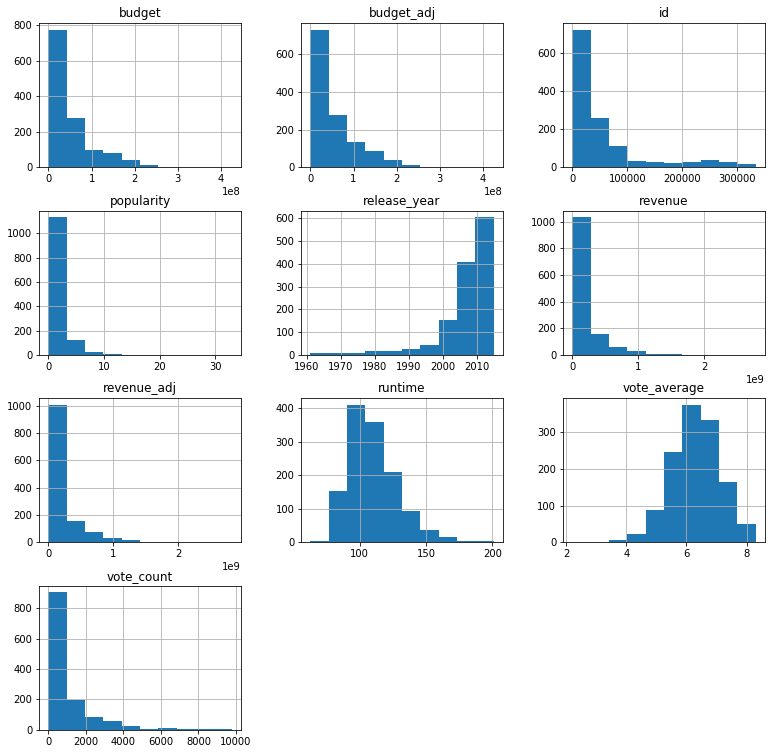

In [24]:
df.hist(figsize=(13,13));


In [25]:
df.describe()


,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,1287.00,1287.00,1287.00,1287.00,1287.00,1287.00,1287.00,1287.00,1287.00,1287.00
mean,52557.49,1.79,52003492.35,176244438.69,110.27,947.27,6.28,2007.02,54629935.84,199177499.23
std,74450.08,2.17,55145404.35,253815575.82,18.81,1255.48,0.80,8.06,55254627.64,296851462.45
min,11.00,0.01,1.00,43.00,63.00,10.00,2.20,1961.00,0.97,43.00
25%,5851.50,0.66,14000000.00,25650969.50,97.00,179.00,5.80,2005.00,15191799.51,27648902.20
50%,20178.00,1.15,32000000.00,82087155.00,107.00,439.00,6.30,2009.00,35569267.40,86747695.58
75%,62209.50,2.13,70000000.00,214069422.00,121.00,1173.00,6.80,2011.00,76301250.18,235117806.64
max,333348.00,32.99,425000000.00,2781505847.00,201.00,9767.00,8.30,2015.00,425000000.00,2827123750.41



### Data Cleaning

 

### In this section the before mentioned "0" will be replaced with nan-Values and will be dropped. Then, the rows with several values will be seperated in single columns containing only one value. This is needed in order to perform a proper analysis. Afterwards, unwanted rows for the analysis will be dropped, before the author will perform general data cleaning action as dropping duplicated lines, correct data types, check duplicated entries in some selected columns.

In [26]:
df['revenue_adj'].replace(0, np.NAN, inplace=True)
df['revenue'].replace(0, np.NAN, inplace=True)
df['budget_adj'].replace(0, np.NAN, inplace=True)
df['budget'].replace(0, np.NAN, inplace=True)
df['runtime'].replace(0, np.NAN, inplace=True)

df.dropna(axis=0, inplace=True)

In [27]:
"""Seperating columns with several values, split by an '|', into as many columns as needed"""
#source: https://apassionatechie.wordpress.com/2018/02/24/how-do-i-split-a-string-into-several-columns-in-a-dataframe-with-pandas-python/

df_c = (df['cast'].str.split('|', expand=True).rename(columns=lambda x: f"cast_{x+1}"))
df_d = (df['director'].str.split('|', expand=True).rename(columns=lambda x: f"director_{x+1}"))
df_k = (df['keywords'].str.split('|', expand=True).rename(columns=lambda x: f"keywords_{x+1}"))
df_g = (df['genres'].str.split('|', expand=True).rename(columns=lambda x: f"genres_{x+1}"))
df_p = (df['production_companies'].str.split('|', expand=True).rename(columns=lambda x: f"production_companies_{x+1}"))

#Checking df_c if split was conducted as intended
df_c.head()

KeyError: 'cast'

In [28]:
"""Joining the seperated columns to the original dataframe and
dropping unneeded columns for the analysis"""

df = df.join([df_c, df_d, df_k, df_g, df_p])
df = df.drop(['cast', 'keywords', 'director', 'genres', 'production_companies', 'imdb_id', 'homepage', 'overview', 'release_date', 'tagline'], axis=1)

ValueError: Indexes have overlapping values: Index(['cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5', 'director_1',
       'director_2', 'director_3', 'director_4', 'director_5', 'director_6',
       'keywords_1', 'keywords_2', 'keywords_3', 'keywords_4', 'keywords_5',
       'genres_1', 'genres_2', 'genres_3', 'genres_4', 'genres_5',
       'production_companies_1', 'production_companies_2',
       'production_companies_3', 'production_companies_4',
       'production_companies_5'],
      dtype='object')

In [29]:

"""Checking number of duplicates"""
df.duplicated().sum()

0

In [30]:
"""Checking if all rows contain the intended data type"""
df.dtypes

id                           int64
popularity                 float64
budget                     float64
revenue                    float64
original_title              object
runtime                    float64
vote_count                   int64
vote_average               float64
release_year                 int64
budget_adj                 float64
revenue_adj                float64
cast_1                      object
cast_2                      object
cast_3                      object
cast_4                      object
cast_5                      object
director_1                  object
director_2                  object
director_3                  object
director_4                  object
director_5                  object
director_6                  object
keywords_1                  object
keywords_2                  object
keywords_3                  object
keywords_4                  object
keywords_5                  object
genres_1                    object
genres_2            

In [31]:
"""Checking column for dubplicated original_title entries"""
limit_4_title = df['original_title'].value_counts().index.tolist()
limit_4_title = limit_4_title[:4]
limit_4_title

limit_4_id = df['original_title'].value_counts().index.tolist()

def check_double_title(names):
    for limit in limit_4_title:
        df_title = df[df['original_title'] == limit]
        print(df_title.iloc[:,:5])
        print("---------------------------------------------------------------------")
        
check_double_title(limit_4_title)

In [32]:
print('Dataframe contains {} rows and {} columns'.format(df.shape[0],df.shape[1]))


Dataframe contains 0 rows and 38 columns


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 Which genres are most popular from year to year?


In [33]:
# Selecting genres columns for the analysis of the original data frame
df_genres = df.loc[:, 'genres_1': 'genres_5' ]
# Adding release year to df_genres
df_genres_dates = df_genres.join(df['release_year'])

In [34]:
years = df_genres_dates['release_year'].unique() #creates an array of years mentioned in release year 
most_common = [] #creates a list of tuples for most common genres in specific years

#for loop to create most_common list
for year in years:
    #creates df filtered by every year mentioned in years
    a = df_genres_dates[df_genres_dates['release_year'] == year] 
    #drops columns "release_year to perferm stack value count in next line
    b = a.drop(['release_year'], axis = 1)
    #performs value count trough genres_1 - genres_5 and stores the index of maximum count
    c = b.stack().value_counts().idxmax() 

    #creates a masked DataFrame for respective years
    x = df[df['release_year'] == year]
    #creates the mean of vote_average and stores the index of maximum value
    y = x.groupby(['genres_1'])['vote_average'].mean().idxmax()
    if c == y:
        z = 'Equal'
    else:
        z = 'Not equal'
        #appends year with value count trough genres_1 - genres_5, the highest average vote_average and indicates if the resulting columns match
    most_common.append((year, c, y, z))

#creates df for list of tuples named most_common
df_most_popular = pd.DataFrame(most_common, columns=['release_year', 'popular_produced_genre', 'popular_voted_gerne', 'is_equal']).sort_values('release_year').reset_index().drop(['index'], axis=1)
df_most_popular

,release_year,popular_produced_genre,popular_voted_gerne,is_equal


In [35]:
df_most_popular['is_equal'].value_counts()


Series([], Name: is_equal, dtype: int64)

### Research Question 2: What kinds of properties are associated with movies that have high revenues?


In [16]:
# Creating a copy of the original DataFrame
df_revenue = df

In [17]:
#Performing basic statistic in order to create 4 classifications of the revenue_adj
df_revenue['revenue_adj'].describe()

count         1287.00
mean     199177499.23
std      296851462.45
min             43.00
25%       27648902.20
50%       86747695.58
75%      235117806.64
max     2827123750.41
Name: revenue_adj, dtype: float64

In [18]:
#Bin_edges correspond to min - max entries in previous cell. Quantiles are lables by bin_names.
#new column 'revenue_level' is created to classify columns based on revenues

bin_edges = [2.37,10465848.09,43956661.16,131648235.91,2827123750.41]
bin_names = ['very low' ,'low' ,'medium' ,'high' ] 
df_revenue['revenue_level'] = pd.cut(df_revenue['revenue_adj'], bin_edges, labels=bin_names)

In [19]:
#list of revenue_levels classification is created for loop in next cell
df_revenue['revenue_level'].unique()
revenue_levels = df_revenue['revenue_level'].unique().tolist()
del revenue_levels[-1]

In [20]:
#nested dictionary is created with 8 attributes based on revenue_levels

movie_data = {}

for level in revenue_levels:
    
    #stack.value_counts seciton
    grouped_data = df_revenue[df_revenue['revenue_level'] == level]
        #director
    director = grouped_data.loc[:, 'director_1': 'director_6']
    frequent_director = director.stack().value_counts().idxmax()
        #cast
    cast = grouped_data.loc[:, 'cast_1': 'cast_5']
    frequent_cast = cast.stack().value_counts().idxmax()
        #genres
    genres = grouped_data.loc[:, 'genres_1': 'genres_5']
    frequent_genres = genres.stack().value_counts().idxmax()
        #production companies
    production = grouped_data.loc[:, 'production_companies_1': 'production_companies_5']
    frequent_production = production.stack().value_counts().idxmax()
        #release_year
    release_year = grouped_data['release_year'].value_counts().idxmax()
    
    #average section
    avg_duration = grouped_data['runtime'].mean()
    avg_budget = grouped_data['budget_adj'].mean()
    avg_vote = grouped_data['vote_average'].mean()
    
    #creating nested dictionary
    movie_data[level] = {'avg_duration' : avg_duration, 
                         'frequent_director' : frequent_director, 
                         'avg_budget' : avg_budget, 
                         'avg_vote' : avg_vote,
                        'frequent_cast' : frequent_cast,
                        'frequent_genres' : frequent_genres,
                        'release_year' : release_year,
                        'frequent_production_companies' : frequent_production}

In [21]:
#https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionaryuser_ids = []
#transforming nested dictionary into dataframe

movie_classes = []
frames = []

for movie_class, d in movie_data.items():
    movie_classes.append(movie_class)
    frames.append(pd.DataFrame.from_dict(d, orient='index'))
    
properties = pd.concat(frames, keys=movie_classes)  

properties.columns = ['values']
properties

values
high     avg_duration                               117.54
         frequent_director                Steven Spielberg
         avg_budget                            95442930.57
         avg_vote                                     6.52
         frequent_cast                          Tom Cruise
         frequent_genres                            Action
         release_year                                 2011
         frequent_production_companies  Universal Pictures
low      avg_duration                               105.01
         frequent_director                  John Carpenter
         avg_budget                            25129745.42
         avg_vote                                     6.17
         frequent_cast                       Colin Farrell
         frequent_genres                             Drama
         release_year                                 2011
         frequent_production_companies  Universal Pictures
medium   avg_duration                               107.83
         frequent_director                  John Carpenter
         avg_budget                            39912951.34
         avg_vote                                     6.17
         frequent_cast                       Jason Bateman
         frequent_genres                             Drama
         release_year                                 2011
         frequent_production_companies        Warner Bros.
very low avg_duration                               102.02
         frequent_director                  Barry Levinson
         avg_budget                            10380165.24
         avg_vote                                     5.99
         frequent_cast                          Ellen Page
         frequent_genres                             Drama
         release_year                                 2010
         frequent_production_companies           Lionsgate

In [22]:
df_revenue.corr()


,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
id,1.00,0.19,-0.05,-0.03,-0.01,0.06,0.00,0.49,-0.12,-0.10
popularity,0.19,1.00,0.43,0.59,0.32,0.74,0.36,0.06,0.42,0.55
budget,-0.05,0.43,1.00,0.71,0.34,0.58,0.08,0.18,0.99,0.57
revenue,-0.03,0.59,0.71,1.00,0.37,0.78,0.30,0.03,0.71,0.91
runtime,-0.01,0.32,0.34,0.37,1.00,0.43,0.39,-0.07,0.36,0.37
vote_count,0.06,0.74,0.58,0.78,0.43,1.00,0.46,0.07,0.57,0.70
vote_average,0.00,0.36,0.08,0.30,0.39,0.46,1.00,-0.16,0.09,0.32
release_year,0.49,0.06,0.18,0.03,-0.07,0.07,-0.16,1.00,0.06,-0.23
budget_adj,-0.12,0.42,0.99,0.71,0.36,0.57,0.09,0.06,1.00,0.61
revenue_adj,-0.10,0.55,0.57,0.91,0.37,0.70,0.32,-0.23,0.61,1.00


<a id='conclusions'></a>
## Conclusions

##### The first research question "Which genres are most popular from year to year?" has shown surprising results, as the most popular genre differed a lot. To the authors surprise, only in 11 occasions the most frequent produced genres was also voted as best genre by the users. In all remaining 40 occasions the two values differed.

##### The second research question "What kinds of properties are associated with movies that have high revenues?" shows interesting result. The numeric columns of "popularity, budget and vote_count" show the highest correlations. One can argue that movies with higher budgets are able to receive higher revenues, nevertheless, the correlation is not on a very high level. Vote_count is indicating that the more people vote for a movie, the higher the revenue is. Most probably, this is not a good indicator for high revenue movies. High revenue movies indicate that they are most commonly directed by Matt Damon, cast Tom Cruise as actor and contain the genre Action



In [23]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0